## Set Up

In [1]:
!pip install torchvision numpy matplotlib scikit-learn tqdm -q

## Models

### NN

In [3]:
import torch
from torch import nn

In [4]:
class FFN(nn.Module):
    def __init__(self, input_size: int = 28*28, output_size: int = 10, dropout_rate: float = 0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x



### ResNet18

In [22]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out = out + self.shortcut(identity)
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, n_channels: int = 3, n_classes: int = 10):
        super().__init__()
        self.initial_conv = nn.Conv2d(n_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, n_classes)

    def _make_layer(self, in_channels: int, out_channels: int, num_blocks: int, stride: int) -> nn.Sequential:
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.bn(self.initial_conv(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class AlexNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Losses

In [15]:
class KDLoss(nn.Module):
    def __init__(self, teacher_model: nn.Module, alpha: float = 0.5, temperature: float = 3.0, class_weights=None):
        super().__init__()
        self.teacher = teacher_model
        self.teacher.eval()
        self.alpha = alpha
        self.T = temperature
        self.ce = nn.CrossEntropyLoss(weight=class_weights)
        self.kl = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits: torch.Tensor, labels: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)

        loss_ce = self.ce(student_logits, labels)
        student_soft = nn.functional.log_softmax(student_logits / self.T, dim=1)
        teacher_soft = nn.functional.softmax(teacher_logits / self.T, dim=1)
        loss_kl = self.kl(student_soft, teacher_soft) * (self.T ** 2)

        return self.alpha * loss_ce + (1 - self.alpha) * loss_kl


class SoftMSELoss(nn.Module):
    def __init__(self, teacher_model: nn.Module):
        super().__init__()
        self.teacher = teacher_model
        self.mse = nn.MSELoss()

    def forward(self, student_logits: torch.Tensor, labels: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            teacher_logits = self.teacher(inputs)

        student_soft = nn.functional.log_softmax(student_logits, dim=1)
        teacher_soft = nn.functional.softmax(teacher_logits, dim=1)
        return self.mse(student_soft, teacher_soft)

## Utils

### Training

In [16]:
import numpy as np
from typing import Literal
from torchvision import datasets, transforms
from torch.utils.data import random_split, Dataset, Subset


def get_dataset(name: Literal['MNIST', 'CIFAR10']):
    if name == 'MNIST':
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(28, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        X_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        X_train, X_val = random_split(X_train, [50000, 10000], generator=torch.Generator().manual_seed(42))
        X_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif name == 'CIFAR10':
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        X_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        X_train, X_val = random_split(X_train, [40000, 10000], generator=torch.Generator().manual_seed(42))
        X_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError(f"Unsupported dataset: {name}")

    return X_train, X_val, X_test

def downsample_dataset(dataset: Dataset, class_label: int, fraction: float) -> Dataset:
    indices = []
    labels = []

    for idx in range(len(dataset)):
        _, label = dataset[idx]
        indices.append(idx)
        labels.append(label)

    labels = np.array(labels)
    indices = np.array(indices)

    downsample_mask = labels == class_label
    keep_indices = indices[~downsample_mask].tolist()
    downsample_indices = indices[downsample_mask]

    n_samples = int(len(downsample_indices) * fraction)
    print(f"Downsampling class {class_label} from {len(downsample_indices)} to {n_samples} samples.")
    np.random.seed(42)
    sampled_indices = np.random.choice(downsample_indices, size=n_samples, replace=False).tolist()

    final_indices = keep_indices + sampled_indices

    return Subset(dataset, final_indices)


def calculate_class_weights(dataset: Dataset, num_classes: int = 10) -> torch.Tensor:
    """Calculate class weights based on the full dataset. For balanced metrics"""
    class_counts = torch.zeros(num_classes)

    for _, label in dataset:
        class_counts[label] += 1

    class_weights = 1.0 / (class_counts + 1e-6)
    class_weights = class_weights / class_weights.sum() * num_classes

    return class_weights

In [17]:
from tqdm import tqdm

def train_model(model: nn.Module,
                train_data: torch.utils.data.Dataset,
                val_data: torch.utils.data.Dataset,
                batch_size: int,
                learning_rate: float,
                num_epochs: int,
                device: torch.device,
                criterion: nn.Module = nn.CrossEntropyLoss(),
):

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_accuracy = 0.0
    metrics = {"val_accuracy": [], "train_loss": [], "val_loss": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            if isinstance(criterion, KDLoss):
                loss = criterion(outputs, labels, inputs)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            train_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        val_criterion = nn.CrossEntropyLoss()
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = val_criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val / len(val_loader.dataset)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        metrics["train_loss"].append(epoch_loss)
        metrics["val_loss"].append(val_loss)
        metrics["val_accuracy"].append(val_accuracy)

    return model, metrics

### Eval

In [18]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

def evaluate_model(model: nn.Module, dataset: Dataset, device: torch.device) -> dict:
    model.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None
    )

    # Macro-averaged metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )

    return {
        'balanced_accuracy': balanced_acc,
        'confusion_matrix': conf_matrix,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'support_per_class': support,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }

def pprint_eval(eval_dict: dict):
    print(f"Balanced Accuracy: {eval_dict['balanced_accuracy']:.4f}")
    print("Per-class Metrics:")
    for i in range(len(eval_dict['precision_per_class'])):
        print(f" Class {i}: Precision: {eval_dict['precision_per_class'][i]:.4f}, "
              f"Recall: {eval_dict['recall_per_class'][i]:.4f}, "
              f"F1-Score: {eval_dict['f1_per_class'][i]:.4f}, "
              f"Support: {eval_dict['support_per_class'][i]}")
    print(f"Macro-Averaged Metrics: Precision: {eval_dict['precision_macro']:.4f}, "
          f"Recall: {eval_dict['recall_macro']:.4f}, "
          f"F1-Score: {eval_dict['f1_macro']:.4f}"
          )

    # add numbers to confusion matrix
    plt.imshow(eval['confusion_matrix'], cmap='Blues')
    for i in range(eval['confusion_matrix'].shape[0]):
        for j in range(eval['confusion_matrix'].shape[1]):
            plt.text(j, i, eval['confusion_matrix'][i, j], ha='center', va='center', color='black')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=range(10))
    plt.yticks(ticks=range(10))
    plt.show()

## Run Eval

### Train Teacher model

#### utils

In [10]:
def train_teacher(model_type: str, dataset_name: str, batch_size: int, learning_rate: float, num_epochs: int, device: str):

    if model_type == 'FFN':
        if dataset_name == 'MNIST':
            input_size = 28 * 28
        elif dataset_name == 'CIFAR10':
            input_size = 32 * 32 * 3
        else:
            raise ValueError("Unsupported dataset")
        teacher_model = FFN(input_size=input_size, output_size=10).to(device)
    elif model_type == 'ResNet':
        if dataset_name == 'MNIST':
            n_channels = 1
        elif dataset_name == 'CIFAR10':
            n_channels = 3
        else:
            raise ValueError("Unsupported dataset")
        teacher_model = ResNet18(n_channels=n_channels, n_classes=10).to(device)
    else:
        raise ValueError("Invalid model type. Choose 'FFN' or 'ResNet'.")

    X_train, X_val, X_test = get_dataset(dataset_name)

    teacher_model, metrics = train_model(
        model=teacher_model,
        train_data=X_train,
        val_data=X_val,
        batch_size=batch_size,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        device=device
    )

    return teacher_model, metrics

#### run

In [121]:
batch_size = 128
learning_rate = 0.001
num_epochs = 7
model_type = 'ResNet' # FFN / ResNet
dataset_name = 'CIFAR10' # MNIST / CIFAR10
device = "cuda"


teacher_model, metrics = train_teacher(
    model_type=model_type,
    dataset_name=dataset_name,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    device=device,
)

Epoch 1/7 [Val]: 100%|██████████| 79/79 [00:04<00:00, 17.81it/s]


Epoch 1/7, Train Loss: 1.5485, Val Loss: 1.4096, Val Acc: 0.4938


Epoch 2/7 [Val]: 100%|██████████| 79/79 [00:04<00:00, 17.97it/s]


Epoch 2/7, Train Loss: 1.0744, Val Loss: 1.5156, Val Acc: 0.5310


Epoch 3/7 [Val]: 100%|██████████| 79/79 [00:04<00:00, 17.83it/s]


Epoch 3/7, Train Loss: 0.8720, Val Loss: 0.9277, Val Acc: 0.6793


Epoch 4/7 [Val]: 100%|██████████| 79/79 [00:04<00:00, 17.72it/s]


Epoch 4/7, Train Loss: 0.7300, Val Loss: 0.7942, Val Acc: 0.7220


Epoch 5/7 [Val]: 100%|██████████| 79/79 [00:04<00:00, 17.61it/s]


Epoch 5/7, Train Loss: 0.6220, Val Loss: 0.6121, Val Acc: 0.7893


Epoch 6/7 [Val]: 100%|██████████| 79/79 [00:04<00:00, 17.68it/s]


Epoch 6/7, Train Loss: 0.5508, Val Loss: 0.7275, Val Acc: 0.7556


Epoch 7/7 [Val]: 100%|██████████| 79/79 [00:04<00:00, 17.52it/s]


Epoch 7/7, Train Loss: 0.4905, Val Loss: 0.6001, Val Acc: 0.8018


Balanced Accuracy: 0.7997
Per-class Metrics:
 Class 0: Precision: 0.7907, Recall: 0.8540, F1-Score: 0.8212, Support: 1000
 Class 1: Precision: 0.9358, Recall: 0.9040, F1-Score: 0.9196, Support: 1000
 Class 2: Precision: 0.8163, Recall: 0.6220, F1-Score: 0.7060, Support: 1000
 Class 3: Precision: 0.5692, Recall: 0.7610, F1-Score: 0.6513, Support: 1000
 Class 4: Precision: 0.7582, Recall: 0.7900, F1-Score: 0.7738, Support: 1000
 Class 5: Precision: 0.7274, Recall: 0.7580, F1-Score: 0.7424, Support: 1000
 Class 6: Precision: 0.9488, Recall: 0.6490, F1-Score: 0.7708, Support: 1000
 Class 7: Precision: 0.8369, Recall: 0.8620, F1-Score: 0.8493, Support: 1000
 Class 8: Precision: 0.8965, Recall: 0.8660, F1-Score: 0.8810, Support: 1000
 Class 9: Precision: 0.8533, Recall: 0.9310, F1-Score: 0.8905, Support: 1000
Macro-Averaged Metrics: Precision: 0.8133, Recall: 0.7997, F1-Score: 0.8006


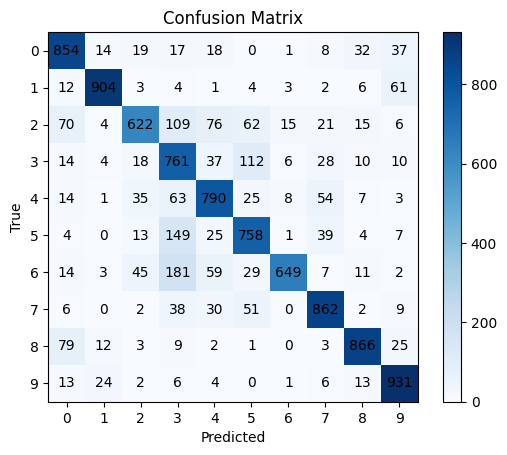

In [122]:
_, _, X_test = get_dataset(dataset_name)
eval = evaluate_model(teacher_model, X_test, device)
pprint_eval(eval)

In [123]:
torch.save(teacher_model.state_dict(), f'teacher_{model_type}_{dataset_name}_batch={batch_size}_lr={learning_rate}_epochs={num_epochs}.pth')

In [95]:
torch.save(teacher_model.state_dict(), f'teacher_AlexNet_{dataset_name}_batch={batch_size}_lr={learning_rate}_epochs={num_epochs}.pth')

### Train Student Model

#### utils

In [24]:
def train_student(model_type: str, dataset_name: str, batch_size: int, learning_rate: float, num_epochs: int, device: str, class_labels_to_remove: list[int], fraction: float, criterion: nn.Module):
    device = torch.device(device)

    if model_type == 'FFN':
        if dataset_name == 'MNIST':
            input_size = 28 * 28
        elif dataset_name == 'CIFAR10':
            input_size = 32 * 32 * 3
        else:
            raise ValueError("Unsupported dataset")
        student_model = FFN(input_size=input_size, output_size=10).to(device)
    elif model_type == 'ResNet':
        if dataset_name == 'MNIST':
            n_channels = 1
        elif dataset_name == 'CIFAR10':
            n_channels = 3
        else:
            raise ValueError("Unsupported dataset")
        student_model = ResNet18(n_channels=n_channels, n_classes=10).to(device)
    else:
        raise ValueError("Invalid model type. Choose 'FFN' or 'ResNet'.")

    X_train, X_val, X_test = get_dataset(dataset_name)

    print(f"Size before downsampling: {len(X_train)}")
    for class_label in class_labels_to_remove:
        X_train = downsample_dataset(X_train, class_label=class_label, fraction=fraction)
        print(f"### Size after downsampling {class_label}: {len(X_train)}")
    print(f"Size after downsampling classes {class_labels_to_remove}: {len(X_train)}")

    student_model, metrics = train_model(
        model=student_model,
        train_data=X_train,
        val_data=X_val,
        batch_size=batch_size,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        device=device,
        criterion=criterion
    )

    return student_model, metrics

#### run

In [21]:
input_size = 28 * 28 # For MNIST dataset
output_size = 10 # For MNIST dataset
device = "cuda"

# Instantiate the FFN model
teacher_model = ResNet18(n_channels=3).to(device)

# Load the state_dict into the model
path = "/content/teacher_ResNet_CIFAR10_batch=128_lr=0.001_epochs=7.pth"
teacher_model.load_state_dict(torch.load(path))

# Set the model to evaluation mode
# teacher_model.eval()

<All keys matched successfully>

In [25]:
batch_size = 128
learning_rate = 0.001
num_epochs = 20

model_type = 'ResNet' # FFN / ResNet
dataset_name = 'CIFAR10' # MNIST / CIFAR10
device = "cuda"

class_labels_to_remove = [0]  # list of ints
remove_fraction = 0.01

### Criterion:
X_train, _, _ = get_dataset(dataset_name)
for class_label in class_labels_to_remove:
    X_train = downsample_dataset(X_train, class_label=class_label, fraction=remove_fraction)
class_weights = calculate_class_weights(X_train, num_classes=10)
print(f"Class weights: {class_weights}")
student_criterion = KDLoss(teacher_model=teacher_model, alpha=0.5, temperature=3.0, class_weights=class_weights).to(device)


student_model, metrics = train_student(
    model_type=model_type,
    dataset_name=dataset_name,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    device=device,
    class_labels_to_remove=class_labels_to_remove,
    fraction=remove_fraction,
    # criterion=nn.CrossEntropyLoss()
    criterion=student_criterion
)

Downsampling class 0 from 4027 to 40 samples.
Class weights: tensor([9.1737, 0.0920, 0.0919, 0.0910, 0.0909, 0.0923, 0.0923, 0.0925, 0.0917,
        0.0917])
Size before downsampling: 40000
Downsampling class 0 from 4027 to 40 samples.
### Size after downsampling 0: 36013
Size after downsampling classes [0]: 36013


Epoch 1/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 19.87it/s]


Epoch 1/20, Train Loss: 4.0380, Val Loss: 1.7166, Val Acc: 0.3919


Epoch 2/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.60it/s]


Epoch 2/20, Train Loss: 2.7143, Val Loss: 1.6530, Val Acc: 0.4827


Epoch 3/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.39it/s]


Epoch 3/20, Train Loss: 2.0620, Val Loss: 1.3811, Val Acc: 0.5629


Epoch 4/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.61it/s]


Epoch 4/20, Train Loss: 1.6730, Val Loss: 1.1596, Val Acc: 0.6088


Epoch 5/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.67it/s]


Epoch 5/20, Train Loss: 1.4844, Val Loss: 1.1872, Val Acc: 0.6322


Epoch 6/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.37it/s]


Epoch 6/20, Train Loss: 1.2770, Val Loss: 1.1367, Val Acc: 0.6461


Epoch 7/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.53it/s]


Epoch 7/20, Train Loss: 1.1958, Val Loss: 1.1327, Val Acc: 0.6571


Epoch 8/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.46it/s]


Epoch 8/20, Train Loss: 1.0814, Val Loss: 0.9745, Val Acc: 0.6969


Epoch 9/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.46it/s]


Epoch 9/20, Train Loss: 0.9758, Val Loss: 0.8813, Val Acc: 0.7145


Epoch 10/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.58it/s]


Epoch 10/20, Train Loss: 0.9169, Val Loss: 0.9222, Val Acc: 0.7012


Epoch 11/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.36it/s]


Epoch 11/20, Train Loss: 0.9378, Val Loss: 0.8626, Val Acc: 0.7293


Epoch 12/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.34it/s]


Epoch 12/20, Train Loss: 0.8145, Val Loss: 0.8230, Val Acc: 0.7419


Epoch 13/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.35it/s]


Epoch 13/20, Train Loss: 0.8408, Val Loss: 0.8135, Val Acc: 0.7431


Epoch 14/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.44it/s]


Epoch 14/20, Train Loss: 0.7717, Val Loss: 0.7248, Val Acc: 0.7650


Epoch 15/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.56it/s]


Epoch 15/20, Train Loss: 0.7565, Val Loss: 0.7365, Val Acc: 0.7620


Epoch 16/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.58it/s]


Epoch 16/20, Train Loss: 0.7136, Val Loss: 0.7844, Val Acc: 0.7443


Epoch 17/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.42it/s]


Epoch 17/20, Train Loss: 0.7062, Val Loss: 0.7539, Val Acc: 0.7626


Epoch 18/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.48it/s]


Epoch 18/20, Train Loss: 0.6726, Val Loss: 0.7042, Val Acc: 0.7733


Epoch 19/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.45it/s]


Epoch 19/20, Train Loss: 0.6420, Val Loss: 0.6835, Val Acc: 0.7791


Epoch 20/20 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.48it/s]

Epoch 20/20, Train Loss: 0.6762, Val Loss: 0.7271, Val Acc: 0.7593


In [26]:
_, _, X_test = get_dataset(dataset_name)

Balanced Accuracy: 0.7586
Per-class Metrics:
 Class 0: Precision: 0.9274, Recall: 0.4090, F1-Score: 0.5677, Support: 1000
 Class 1: Precision: 0.9026, Recall: 0.9080, F1-Score: 0.9053, Support: 1000
 Class 2: Precision: 0.7045, Recall: 0.6700, F1-Score: 0.6868, Support: 1000
 Class 3: Precision: 0.5052, Recall: 0.7730, F1-Score: 0.6111, Support: 1000
 Class 4: Precision: 0.7315, Recall: 0.7820, F1-Score: 0.7559, Support: 1000
 Class 5: Precision: 0.7426, Recall: 0.6550, F1-Score: 0.6961, Support: 1000
 Class 6: Precision: 0.8265, Recall: 0.8480, F1-Score: 0.8371, Support: 1000
 Class 7: Precision: 0.9323, Recall: 0.7020, F1-Score: 0.8009, Support: 1000
 Class 8: Precision: 0.7813, Recall: 0.9290, F1-Score: 0.8488, Support: 1000
 Class 9: Precision: 0.7892, Recall: 0.9100, F1-Score: 0.8453, Support: 1000
Macro-Averaged Metrics: Precision: 0.7843, Recall: 0.7586, F1-Score: 0.7555


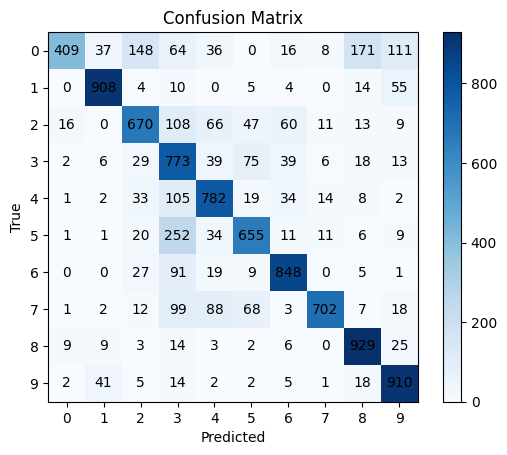

In [27]:
eval = evaluate_model(student_model, X_test, device)
pprint_eval(eval)

In [37]:
torch.save(student_model.state_dict(), f'student_{model_type}_{dataset_name}_batch={batch_size}_lr={learning_rate}_epochs={num_epochs}_classes_removed={class_labels_to_remove}_fraction={remove_fraction}.pth')

In [50]:
torch.save(student_model.state_dict(), f'normal_downsampled_{model_type}_{dataset_name}_batch={batch_size}_lr={learning_rate}_epochs={num_epochs}_classes_removed={class_labels_to_remove}_fraction={remove_fraction}.pth')

In [28]:
torch.save(student_model.state_dict(), f'student_AlexNet_{dataset_name}_batch={batch_size}_lr={learning_rate}_epochs={num_epochs}_classes_removed={class_labels_to_remove}_fraction={remove_fraction}.pth')